# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> RcTorch Library Paper Experiments
## Forced Pendulum

**Harvard University**<br/>
**Hayden Joy**<br/>


<hr style="height:2pt">

rctorch github repository: https://github.com/blindedjoy/RcTorch

In [1]:
#entire modules
import numpy as np
import pandas as pd
import scipy
import torch
import pickle
import os

#sub-modules

import matplotlib.pyplot as plt
from numpy import loadtxt
import scipy.signal as signal

#from pyESN import ESN
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
#import pandas as pd


from scipy.spatial.distance import correlation as corr
from scipy.integrate import odeint

from matplotlib.pyplot import cm
from matplotlib import cm
%matplotlib inline

In [2]:
from matplotlib.colors import LogNorm, Normalize
plt.rcParams.update({"text.usetex": True})

In [3]:
np.__version__

'1.23.0'

In [4]:
pd.__version__

'1.3.4'

### to install rctorch in jupyterhub-gpu open a terminal and then enter:
`>>> pip3 install rctorchprivate`
if that fails first try `pip3 install botorch`

In [5]:
#pip uninstall rctorchprivate

In [6]:
cd /Users/hayden/Desktop/RcTorch/RcTorch-private/

/Users/hayden/Desktop/RcTorch/RcTorch-private


In [7]:
from rctorchprivate import *

In [8]:
ls rctorchprivate

Misc/           __pycache__/    custom_loss.py  misc.py         rc_helpers.py
Untitled.ipynb  activations.py  data.py         rc.py
__init__.py     backprop.py     defs.py         rc_bayes.py


### Important tasks before submission

0. Fix the plots for Marios (just axis label size basicallly)
    0. The finished plot is types of trajs
    1. Figure iconic needs larger tick marks, axis labels
    2. Figure ... needs ...
    3. Figure ... needs ...
1. Clean up this notebook. Potentially even break it up so that it is easy to read and use for documentation purposes.
2. Add lists of acceptable arguments so that RcTorch can't take any arbitrary argument
3. Get Pavlos to read the paper.

# RcTorch: 

RcTorch is a GPU accelerated pytorch library that uses Facebook's bayesian optimization package BoTorch to quickly optimize the hyper-parameters of reservoir nueral networks. This library is still in its early stages so feel free to email Hayden Joy hjoy@college.harvard.edu with any questions or to report any bugs. For this reason please also check for updates here: https://pypi.org/project/rctorch/.

(a huge thank you to Reinier https://github.com/1Reinier/Reservoir who wrote the first version of this library and most of this documentation. See the paper here: https://arxiv.org/abs/1903.05071)

J. R. Maat, N. Gianniotis, “Reservoir: a Python Package to Train and Optimize Echo State Networks ,” 2017. [Online]. Available: http://github.com/https://github.com/1Reinier/Reservoir

The open source code in this package supplements:
J. R. Maat, N. Gianniotis and P. Protopapas, "Efficient Optimization of Echo State Networks for Time Series Datasets," 2018 International Joint Conference on Neural Networks (IJCNN), Rio de Janeiro, 2018, pp. 1-7.

### The EchoStateNetwork class creates a reservoir neural network according to the following arguments
log-space variables: 
- connectivity: **[float]** the probability that two nodes will be connected
- regularization: **[float default value None]** The L2 regularization value used in Ridge regression for model inference
    
lin-space variables: 
- bias **[recommended value 1.5]**: bias to be added to the input weights.
- leaking_rate **[float recommended value: ]**: Specifies how much of the state's update 'leaks' into the new state
- spectral_radius **[float search between 1 and 2]**: Sets the magnitude of the largest eigenvalue of the transition matrix (weight matrix) 

Variables we recommend you fix: 
 - n_nodes **[recommended value 1000]**: Number of nodes that together make up the reservoir
 - input_scaling: **[float, default value 0.5]**
     The scaling of input values into the network
 - feedback scaling: **[float, default value 0.5]** the scaling of feedback values into the network
 
Other arguments:
 - feedback: **[bool]** Sets feedback of the last value into the network on or off (for predictions predicted values are substituted for y)
 - random seed: **[int]** Seed used to initialize RandomState (Torch Generator manual seed) in reservoir generation and weight initialization
 - activation function: **[nn.function]** recurrent activation function. only nn.tanh implimented. Leave as is
 
### The EchoStateNetworkCV class performs cross-validated Bayesian Optimization on variables of your choice

Arguments:
- bounds = The bounds dict declares trainable and fixed variables. Certain variables are searched in log-space and other are in lin-space. All variables are the dictionary keys. if a numeric value (not a tuple) is assigned to a variable (ie hyper-parameter) it is assumed to be fixed. If it is assigned to be a tuple then then the value is ([lower bound], [upper bound]). 
- intial samples: **[int recommended value >= 50]** The number of random samples to explore before starting the optimization.
- validate_fraction **[float ]** the fraction of the data that may be used as a validation set
- batch_size: **[int]** Batch size of samples used by BoTorch (these are run in parallel and with cuda if possible)
- cv_samples: **[int]** number of samples of the objective function to evaluate for a given parameterization of the ESN
- scoring method: {'mse', 'nmse'} Evaluation metric that is used to guide optimization
- esn_burn_in: **[int]** the number of time steps to discard upon training a single Echo State Network
- esn_feedback: builds ESNs with feedback ('teacher forcing') if available
- device: Torch device (either 'cpu' or 'cuda')
- interactive **[BOOL]** if true, make interactive python plots
- approximate reservoir **[BOOL NOT IMPLIMENTED]** use sparse matrices to speed up optimization
- activation function: **[nn.function]** only nn.tanh implimented

Trust Region Bayesian Optimization (TURBO) 

TURBO Arguments: (<a href='https://botorch.org/tutorials/turbo_1'>Botorch tutorial</a>) (<a href='https://arxiv.org/pdf/1910.01739.pdf'> click here for the original paper</a>  which came out of uber.
Turbo Arguments *we don't recommend that you change these values but they are here for your understanding)*
- failure tolerance [**int, automated**] the number of times that a model can fail to improve length before length is increased in turbo algorithm.
- sucess tolerance: [**int**] the number of times that a model can succeed to improve length before length is decreased in turbo algorithm.
- length min: [**int**] the target length that acts as the stopping condition for the turbo algorithm
- length max: [**int**] maximum length that the turbo algorithm can take before
    
Further arguments
- windowsOS: [**bool**] NOT IMPLIMENTED: use this if you have a windows system with a GPU
- steps ahead: leave as None. Vestigal argument.

     
    
    

### Helper Functions

In [9]:
def adjust_np_data(arr):
    """
    """
    tensor = torch.tensor(arr, dtype = torch.float32)
    return tensor.unsqueeze(1)

def get_split_t(t, input_train):
    """split time
    """
    t_tr = t[:input_train.shape[0]]
    t_te = t[input_train.shape[0]:]
    return t_tr, t_te

def correlation_test(esn_model, 
                     n_hidden_states : int = 203, 
                     plot : bool = False,
                     verbose : bool = False
                    ):
    """Check the correlation between the hidden states of the echostate network
    
    This function could be parallelized if desired.
    
    Arguments
    ---------
    esn_model : RcTorch.RcNetwork model
        a reservoir computer is also called an echo-state network, or esn for short
    n_hidden_states: int
        the number of hidden states
    plot: bool
        if true plot a heatmap
    
    Returns
    -------
    mean_corr: float
        the mean correlation between the hidden states
    """
    n = n_hidden_states
    corr = signal.correlate
    corr = np.correlate
    matt = np.zeros((n,n))
    
    #here we store the magnitude of the output weight
    mags = []
    for i in range(1, n):
        
        #hidden state i
        hh1 = esn_model.extended_states[:,i]
        
        mag_i = float(esn_model.LinOut.weight.ravel()[i])* float(hh1.abs().sum())
        mags.append(mag_i)
        for j in range(n):
            
            #hidden state j
            hh2 = esn_model.extended_states[:,j]
            if i == j:
                matt[i,j] = 1
            else: 
                matt[i,j] = corr(hh1.ravel().numpy(), hh2.ravel().numpy())
                matt[i,j] = np.abs(matt[i,j])
        
    if plot:  
        sns.heatmap(matt)
        plt.show()
        plt.hist(matt)
        plt.show()
    mean_corr = matt.mean()
    if verbose:
        print('mean magnitude', np.array(mags).mean())
        print("Mean correlation: ", mean_corr)
        print("dot product standard deviation: ", matt.std())
    return mean_corr

### Some different options for $\alpha$ and $\omega$ in the driven force equation where the force $f=\alpha\sin{\omega t}$

In [10]:
# #pretty set! (try both sincos and sin)
# As = np.ones(5)
# Ws = [10**i for i in [1, 0, -1, -2, -3]]

# #pretty set!
# base = np.pi/13 * 10
# Ws = np.array([base**i for i in [2, 1, -0.95, -1, -2, -3]])

base = np.exp(1)
#alphas
As = np.ones(5)/2
#omegas
Ws = np.array([base**i for i in [2, 1, -0.95, -1, -2, -3]])

#AW_lst = [(0, 0), (0.2, 0.2),  (0.3, 0.3), (0.1, 0.01)]
AW_lst = list(zip(As, Ws))

In [11]:
datas, inputs, t = synthetic_data(desired_length=np.pi * 60, AW_lst = AW_lst)

0.5 7.3890560989306495
0.5 2.718281828459045
0.5 0.38674102345450123
0.5 0.36787944117144233
0.5 0.1353352832366127


In [12]:
datas[0][0].shape

torch.Size([11999, 2])

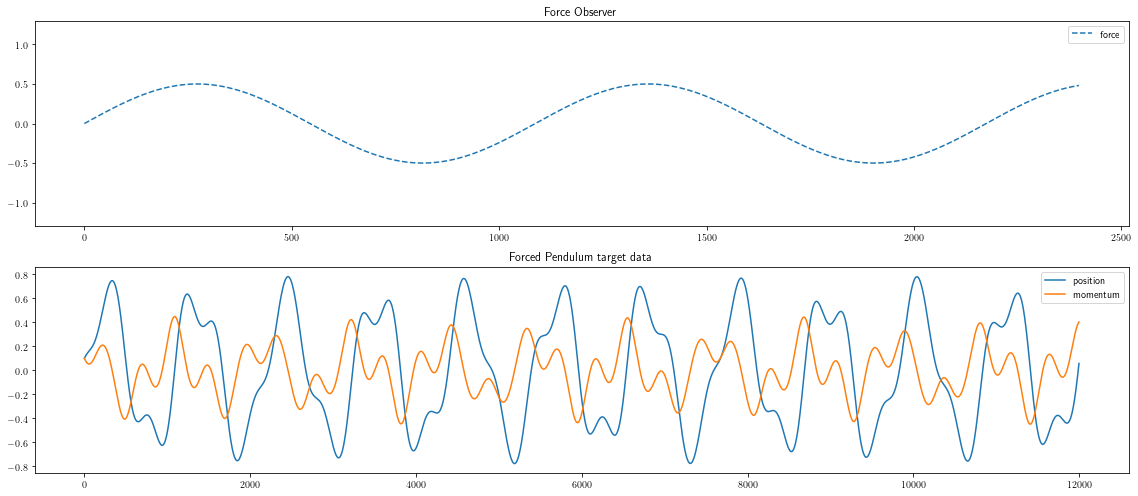

In [13]:
problem = 3
idx = 0
input_train, input_test, target_train, target_test = split_data( inputs[problem][idx], datas[problem][idx], 0.2) #0.2
plot_data(datas[problem][idx], force = input_train)

#### Pure Prediction RC

In [14]:
%%time

#main_section
hps = {'connectivity': 0.4071449746896983,
 'spectral_radius': 1.1329107284545898,
 'n_nodes': 202,
 'regularization': 1.6862021450927922,
 'leaking_rate': 0.009808523580431938,
 'bias': 0.48509588837623596}

# opt_hps = {'connectivity': 0.4071449746896983,
#  'spectral_radius': 1.1329107284545898,
#  'n_nodes': round(201.7901153564453),
#  'regularization': 1.6862021450927922,
#  'leaking_rate': 0.009808523580431938,
#  'bias': 0.48509588837623596}
RANDOM_STATE = 210
#plot_data(datas[problem][idx], force = input_train)

CPU times: user 6 µs, sys: 22 µs, total: 28 µs
Wall time: 8.82 µs


In [15]:
%%time
esn_pure_pred = RcNetwork(**hps, feedback = True, random_state = RANDOM_STATE) # was 210
esn_pure_pred.fit(y = target_train)
score, prediction = esn_pure_pred.test( y = target_test)
score

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 2399 but got size 5752803 for tensor number 1 in the list.

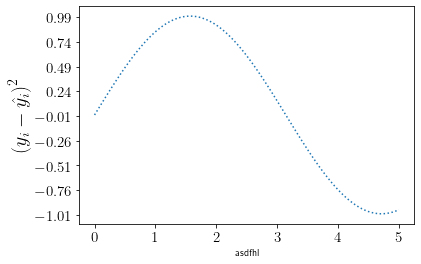

In [16]:
x = np.linspace(0,5,100)
y = np.sin(x)
plt.plot(x,y,linestyle=':')
plt.ylabel(r'$\left(y_i-\hat{y_i}\right)^2$', fontdict= {"fontsize" : 20})

plt.tick_params(labelsize = 15)

plt.yticks(np.arange(-1.01, 1.01, 0.25))
plt.xlabel(None)
plt.xlabel("asdfhl")
plt.show()

In [17]:

t_tr, t_te = get_split_t(t, input_train)
t_tr.shape, input_train.shape

((2399,), torch.Size([2399]))

In [18]:
lpad = 0.04

In [19]:
colors = {'color_rc' : "brown", 
          #'color_gt' : "midnightblue", 
          'color_noise':  'peru',
          'linewidth' : 1,
          'alpha' : 0.9,
          'noisy_alpha' : 0.4,
          'noisy_s' : 1,
          'pred_linestyle' : "-.",
          'color_map': cm.afmhot_r}

In [20]:
tight_layout_args = {'w_pad' : 0.00, 'h_pad' : 0.1, 'pad' : 0.01 }
plotting_args = {'axis_label_fontsize' : 29, 
                 'ylabel_pred' : r'$x$, $p$', 
                 'ylabel_resid' : r'$MSE$',#r'$\left(y-\hat{y}\right)^2$',
                 'tick_fontsize' : 27, 
                 'grid_spec_x' : 7,
                 'resid_blocks' : 4,
                 'tight_layout_args' : tight_layout_args}

In [21]:
esn_pure_pred.combined_plot(t_tr = t_tr, t_te = t_te, **plotting_args)
                           
print(f"score: {score}")
plt.savefig('../fig/traj_1.pdf', dpi=2400, bbox_inches='tight')
final_figure_plot(target_test, None, prediction, 
                  **colors, 
                  label_fontsize = 25,
                  figsize = (9, 4.5)
                 )#, tick_fontsize = 22)
plt.savefig('../fig/phase_1.pdf', dpi=2400, bbox_inches='tight')

AttributeError: 'RcNetwork' object has no attribute 'y_val'

In [ ]:
plt.tight_layout(w_pad = 0.05, h_pad = 0.08, pad = 0.01 )

In [ ]:
pp1_corr = correlation_test(esn_pure_pred)

#### Parameter Aware RC plot 1 (observer)

In [ ]:
%%time
esn_pure_pred = RcNetwork(**hps, 
            random_state = RANDOM_STATE, 
            feedback = True,
            activation_function = "tanh")

esn_pure_pred.fit(X = input_train, 
                  y = target_train)

score, prediction = esn_pure_pred.test(X = input_test, y = target_test)

In [ ]:
t_tr, tr_te = get_split_t(t, input_train)
esn_pure_pred.combined_plot(t_tr = t_tr, t_te = tr_te, **plotting_args)
plt.savefig('../fig/traj_2.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

In [ ]:
#plt.colorbar()
hi = np.random.rand(10,10)
bye = np.random.rand(10,10)*0.5
diff = (hi-bye).mean(axis = 1)
diff.shape

In [ ]:
#len(dif)

In [ ]:
fig, ax = plt.subplots(1,1)
cmap = cm.magma
plt.scatter(range(len(diff)), diff, color = cm.magma(diff**2/(diff**2).max()))
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)

In [ ]:
colors

In [ ]:
final_figure_plot(test_gt = target_test, 
                  noisy_test_gt = None, 
                  rc_pred = prediction, 
                  **colors,
                  label_fontsize = 25, 
                  #tickfontsize = 22
                  figsize = (9, 4.5)
                  )
fig.colorbar(cm.ScalarMappable(cmap=cmap), ax=ax)
plt.savefig('../fig/phase_2.pdf', dpi=2400, bbox_inches='tight')
print(f'score : {score}')
#plt.colorbar()


In [ ]:
#assert False

In [ ]:
obs1_corr = correlation_test(esn_pure_pred)

#### Parameter Aware RC plot 2 (multiple activation functions and output activation)

In [ ]:
final_figure_plot

In [ ]:
colors

In [ ]:
colors['color_gt'] = None

In [ ]:
%%time

esn_pure_pred = RcNetwork(**hps, 
                           #reservoir_weight_dist = "normal",
                           output_activation = "tanh",
                           activation_function = {"tanh" : 0.1, 
                                   "relu" : 0.9, 
                                   "sin": 0.05},
#                            activation_function = {"tanh" : 0.33, 
#                                    "relu" : 0.33, 
#                                    "sin": 0.33},
                           random_state = RANDOM_STATE, 
                           feedback = True)
esn_pure_pred.fit(X = input_train, 
                  y = target_train,
                  burn_in = 0)

score, prediction = esn_pure_pred.test(X = input_test,
            y = target_test)

esn_pure_pred.combined_plot(t_tr = t_tr, t_te = t_te, **plotting_args)
plt.savefig('../fig/traj_3.pdf', dpi=2400, bbox_inches='tight')
final_figure_plot(target_test, None, prediction, 
                  **colors, 
                  figsize = (9, 4.5),
                  label_fontsize = 25)

plt.savefig('../fig/phase_3.pdf', dpi=2400, bbox_inches='tight')
print(score)

In [ ]:
#dir(cm)

In [ ]:
x = np.linspace(0, 2*np.pi, 1000)
y = np.sin(2*x)

plt.scatter(x,y, c=cm.gnuplot2_r(np.abs(y)), edgecolor='none')

In [ ]:
obs2_corr = correlation_test(esn_pure_pred)

In [ ]:
plt.figure(figsize = (6,6))
df = pd.DataFrame({f"pure prediction" : pp1_corr, 
                   f"parameter aware" : obs1_corr, 
                   f"multiple activations" : obs2_corr}, index = [0])
df = df.melt()
df.columns = ["model","correlation"]

sns.barplot(data = df, x = "model", y = "correlation" )
plt.show()

## Noise HPs

In [ ]:
noise_sigma =  0.1

In [ ]:
datas, inputs, t = synthetic_data(desired_length=np.pi * 100, AW_lst = AW_lst)
noise_hps = {'n_nodes': 500,
 'connectivity': 0.6475559084256522,
 'spectral_radius': 1.0265705585479736,
 'regularization': 61.27292863528506,
 'leaking_rate': 0.010949543677270412,
 'bias': 0.5907618999481201,
      }

problem = 2
idx = 2
input_train, input_test, target_train, target_test = split_data( inputs[problem][idx], 
                                                                 datas[problem][idx],
                                                                 0.4)
plt.plot(datas[problem][idx][:4000])
final_figure_plot(datas[problem][idx], None, datas[problem][idx],
                  **colors)
plt.show()
#correlation_test(esn_pure_pred)

In [ ]:
def normal_like(arr_, sigma):
    mus = torch.zeros_like(arr_)
    sigmas = torch.ones_like(arr_)*sigma
    return torch.normal(mean = mus, std = sigmas)

# # input_train, input_test, target_train, target_test = input_train2, input_test2, target_train2, target_test2
# # plt.plot(datas[problem][idx][:4000])
# final_figure_plot(datas[problem][idx], None, datas[problem][idx])

GAUSSIAN_NOISE = True
if GAUSSIAN_NOISE:
    
    noisy_target_tr = target_train + normal_like(target_train, noise_sigma)
    noisy_target_te = target_test +  normal_like(target_test, noise_sigma)
else:

    noisy_target_tr = target_train + (torch.rand_like(target_train)-0.5) * noise_sigma
    noisy_target_te = target_test + (torch.rand_like(target_test)-0.5) * noise_sigma

In [ ]:
len(noisy_target_tr), len(noisy_target_te)

In [ ]:
%%time
RC_noise1 = RcNetwork(**noise_hps, feedback = True, 
                      activation_function = "tanh",
#                       activation_function = {"tanh" : 0.1, 
#                                    "relu" : 0.9, 
#                                    "sin": 0.05},
            random_state = RANDOM_STATE) # was 210
RC_noise1.fit(y = noisy_target_tr)
score, prediction1 = RC_noise1.test( y = noisy_target_te)


RC_noise1.combined_plot(gt_tr_override = target_train, gt_te_override = target_test)
print(f"score: {score}")


In [ ]:
def adjust_labelsize(ax = None):
    plt.sca(ax)
    plt.xticks(fontsize=label_fontsize)
    plt.yticks(fontsize=label_fontsize)

In [ ]:
noise_phaseplot_args = {'figsize' : (10,4), 
                        'noise_xlim' : (-1.2, 1.2),
                        'noise_ylim' : (-0.75, 0.75),
                        "label_fontsize" : 20,
                        **colors}

#colors['color_gt'] = None#'midnightblue'
final_figure_plot(test_gt = target_test, 
                  noisy_test_gt = noisy_target_te, #'cadetblue',#'slateblue',
                  rc_pred = prediction1, 
                  **noise_phaseplot_args,
                  
                   )
plt.show()
noise_corr_1 = correlation_test(RC_noise1)
print("Try changing xaxis to be the same across all of them")
print("Change the function so that it has less arguments, dictionaries directly to key plotting functions")

In [ ]:
%%time
rc_noise2 = RcNetwork(**noise_hps, 
            random_state = RANDOM_STATE, 
            feedback = True)
            #output_activation = "tanh")
#             activation_function = {"tanh" : 0.1, 
#                                    "relu" : 0.9, 
#                                    "sin": 0.05})#activation_function = "tanh")

rc_noise2.fit(X = input_train, 
                  y = noisy_target_tr, 
                  burn_in = 0)

score, prediction2 = rc_noise2.test(X = input_test,
            y = noisy_target_te)

In [ ]:
#{'pad'=0.4, 'w_pad'=0.5, 'h_pad'=1.0}

In [ ]:
rc_noise2.combined_plot(gt_tr_override = target_train,
                        gt_te_override = target_test,
                        ylabel_pred = r'$y$, $p$', 
                        ylabel_resid = r'$MSE$',
                        axis_label_fontsize = 25, 
                        tick_fontsize = 22)
plt.show()
noise_corr_2 = correlation_test(rc_noise2)
#print(f"score: {score}")


In [ ]:
noise_phaseplot_args

In [ ]:
final_figure_plot(target_test, 
                  noisy_target_te,
                  prediction2,
                  **noise_phaseplot_args)

                  #ylim_low = -0.8, ylim_high = 0.8)
plt.savefig('../fig/rctorch_phase_plot_iconic.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
colors

In [ ]:
phaseplot_quad_args = noise_phaseplot_args.copy()
phaseplot_quad_args['figsize'] = 6.5, 6 #6.25
#(6.5,6) was the figsize before rotating the x axis labels
phaseplot_quad_args['label_fontsize'] = 20

In [ ]:
phaseplot_quad_args

In [ ]:
print(f"score: {score}")
plt.rcParams.update({
    "text.usetex": True})
final_figure_plot2(target_test, 
                  noisy_target_te, 
                  prediction1,
                  prediction2,
                  #rotate_xaxis_label = False,
                  #title_fontsize = 15,
                  #color_noise = "peru",
                  #label_fontsize = 25,
                  **phaseplot_quad_args)
                  #figsize = (7, 8))
plt.savefig('../fig/rctorch_noise_phase.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
phaseplot_quad_args = noise_phaseplot_args.copy()
phaseplot_quad_args['figsize'] = 6.5, 6.1 #6.25
#(6.5,6) was the figsize before rotating the x axis labels
phaseplot_quad_args['label_fontsize'] = 20

In [ ]:
print(f"score: {score}")
plt.rcParams.update({
    "text.usetex": True})
final_figure_plot2(target_test, 
                  noisy_target_te, 
                  prediction1,
                  prediction2,
                  #rotate_xaxis_label = True,
                  #title_fontsize = 15,
                  #color_noise = "peru",
                  #label_fontsize = 25,
                  **phaseplot_quad_args)
                  #figsize = (7, 8))
plt.savefig('../fig/rctorch_noise_phase.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
# %%time
# rc_noise3 = RcNetwork(**noise_hps, 
#             random_state = RANDOM_STATE, 
#             feedback = True,
#             #output_activation = "tanh")
#             activation_function = {"tanh" : 0.33, 
#                                    "relu" : 0.33, 
#                                    "sin": 0.33})#activation_function = "tanh")

# rc_noise3.fit(X = input_train, 
#                   y = noisy_target_tr, 
#                   burn_in = 0)

# score, prediction3 = rc_noise3.test(X = input_test,
#             y = noisy_target_te)



In [ ]:
# noise_corr_3 = correlation_test(rc_noise3)

In [ ]:
# plt.figure(figsize = (6,6))
# df = pd.DataFrame({f"noise RC 1" : noise_corr_1, 
#                    f"noise RC 2" : noise_corr_2,
#                    f"noise RC 3" : noise_corr_3}, index = [0])
# df = df.melt()
# df.columns = ["model","correlation"]

# sns.barplot(data = df, x = "model", y = "correlation" )
# plt.show()

### BEGIN BO SECTION

#### Load data (notice here we use a larger dt). This will dramatically speed up the process.

In [ ]:
datas, inputs, t = synthetic_data(force = "sincos", 
                               dt = np.pi /(20), 
                               desired_length = np.pi *300,
                               AW_lst =  [(0.5, 0.6)])


### Bayesian optimization Demo

First lets investigate what type of behavior may have been causing the increase in the loss function. That is, does the data generated by our integrator for this equation look different that the phase space of the original problem data?

#TODO remove noise parts from this section

In [ ]:
noise = 0.1
problem, idx = 0, 0
input_tr, input_te, target_tr, target_te = split_data( inputs[problem][idx], datas[problem][idx], 0.6) #0.2

# noise_target_tr = target_tr + torch.rand_like(target_tr)*noise
# noise_target_te = target_te + torch.rand_like(target_te)*noise
# input_tr.shape, noise_target_tr.shape

In [ ]:
plt.figure(figsize = (12,4))
plt.plot(target_tr[:1000])
plt.axis('off')

In [ ]:
# #declare the bounds dict. See above for which variables are optimized in linear vs logarithmic space.
bounds_dict = { "connectivity" : (0,1),
                #"log_connectivity" : (-2, -0.1), 
               "spectral_radius" : (0.6, 2),
               #"n_nodes" : (350, 353.1),
               "n_nodes" : (1, 353.1),
               "log_regularization" : (-3, 3),
               "leaking_rate" : (0, 1),
               #"input_scaling" : (0, 1),
               "input_connectivity" : (0, 1),
               "feedback_connectivity" : (0, 1),
               "bias": (0, 1),
               #"mu" : (-1, 1),
               #'sigma': 0.0015868513697625247, #"sigma" : (-3, 0.1),
               #"noise" :(-3, 0)
               
               }

#declare the esn_cv optimizer: this class will run bayesian optimization to optimize the bounds dict.
opt = False
if opt:
    rc_bayes = RcBayesOpt(bounds = bounds_dict, feedback = True, 
                                 interactive = True, 
                                n_jobs = 4, cv_samples = 1, initial_samples = 12, 
                                random_seed = 210,
                          activation_function = "tanh", #changed to tanh while working on docs
#                           activation_function = {"tanh" : 0.1, 
#                                    "relu" : 0.9, 
#                                    "sin": 0.05},
                               reservoir_weight_dist = "uniform")
                                #                                 n_inputs = 1,
                                #                                 n_outputs = 2)
                              #activation_function = torch.sin,
                              #act_f_prime = torch.cos)
    #optimize:
    opt_hps = rc_bayes.optimize( n_trust_regions = 1, 
                                  max_evals = 2000,
                                  x = input_tr, 
                                  scoring_method = "nmse",
                                  y = target_tr)

In [ ]:
#rc_bayes.recover_hps()

In [ ]:
# 0)
problem = 0
idx = 0
input_tr, input_te, target_tr, target_te = split_data( inputs[problem][idx], datas[problem][idx], 0.4) #0.2

In [ ]:
plot_data(data = datas[problem][idx], force = inputs[problem][idx])
#final_figure_plot(target_te, None, target_te)

### With the hps from the main paper:

In [ ]:
%%time

main_section_hps = {'connectivity': 0.4071449746896983,
 'spectral_radius': 1.1329107284545898,
 'n_nodes': 202,
 'regularization': 1.6862021450927922,
 'leaking_rate': 0.009808523580431938,
 'bias': 0.48509588837623596}

esn_pure_pred = RcNetwork(**main_section_hps,
                          activation_function = 
                          {"tanh" : 0.1, 
                                   "relu" : 0.9, 
                                   "sin": 0.05},
                          #activation_function = {'tanh':0.1, 'relu':0.9},
                          feedback = True,
                          
                          random_state = 210) # was 210
esn_pure_pred.fit(X = input_tr, y = target_tr, )#X = input_tr, y = target_tr) #input_te
score, prediction_old_hps = esn_pure_pred.test( X = input_te, y = target_te, scoring_method = "nmse")#input_te, y = target_te)
# esn_pure_pred.combined_plot()
# final_figure_plot(target_te, None, prediction_old_hps)
print(score)

In [ ]:
bo_corr_1 = correlation_test(esn_pure_pred)

In [ ]:
%%time
# With activation from the optimized version

#w = 7
reoptimized_hps = {'connectivity': 0.027590717637616207,
 'spectral_radius': 1.8042035102844238,
 'n_nodes': int(352.14581298828125),
 'regularization': 1.3773347868659582,
 'leaking_rate': 0.36422401666641235,
 'input_connectivity': 0.9941699504852295,
 'feedback_connectivity': 0.8125365972518921,
 'bias': 0.7468461394309998}

esn_pure_pred = RcNetwork(**reoptimized_hps,
                          activation_function = {"tanh" : 0.1, 
                                                 "relu" : 0.9, 
                                                  "sin": 0.05},
#                           activation_function = {"relu" : 0.33, 
#                                                  "tanh" : 0.5, 
#                                                  "sin" : 0.1},
                          #activation_function = {'tanh':0.1, 'relu':0.9},
                          feedback = True,
                          
                          random_state = 210) # was 210
esn_pure_pred.fit(X = input_tr, y = target_tr)
score, prediction_new_hps = esn_pure_pred.test( X = input_te, y = target_te)
esn_pure_pred.combined_plot()
#final_figure_plot(target_te, None, prediction_new_hps )


print(score)

In [ ]:

def final_figure_plot2(test_gt, noisy_test_gt, rc_pred1, rc_pred2, 
                       color_noise = None, 
                       color_gt = None, 
                       color_rc = 'brown', 
                       alpha = None,
                       noisy_format = '.', 
                       
                       linestyle = '--', 
                       pred_linestyle = "-.",
                       noise_linestyle = ".", 
                       
                       linewidth = 1,
                       pred_linewidth = 1,
                       noise_linewidth = 2,
                       
                       label_fontsize = 22, 
                       title_fontsize = 18, 
                       noisy_alpha = 0.4,
                       noisy_s = 1,
                       figsize = (9,4), 
                       legend = False, 
                       alphas = None,
                       noise_xlim = None,
                       noise_ylim = None,
                       color_map = None,
                       #"label_fontsize" : 20,
                       rotate_xaxis_label = True,
                       magma = False):
    
    # arg_dict = {#"label" : label,
    #             "alpha" : alpha,
    #             "linestyle" : linestyle,
    #             "linewidth" : linewidth}
    tick_font_reduction = 4
    tff = tick_fontsize = label_fontsize-tick_font_reduction
    
    def _phase_plot(tensor_, label, alpha = 0.9, 
                   color = None, magma = magma, 
                   other_val = None, 
                   linestyle = None, 
                   linewidth = None,
                   s = None):
        arg_dict = {"label" : label,
                    "alpha" : alpha,
                    "linewidth" : linewidth,
                    "linestyle" : linestyle}



        x1, x2 = tensor_[:,0], tensor_[:,1]
        

        if not magma:
            #for the noisy data:
            if linestyle == "." :
                plt.scatter(x1, x2, alpha = arg_dict['alpha'], color = color, s = s)
            else:

                plt.plot(x1, x2, **arg_dict, color = color)
        elif magma:
            #resids = ((tensor_ - other_tensor)**2).mean(axis = 1)
            plt.scatter(x1, x2, c=color_map_, edgecolor='none')
        else:
            assert False, f'magma argument: {magma} must be a boolean.'

               


    
    #plot 1 is the real phase space of the  virgin target test set
    if noisy_test_gt is not None:
        
       
        fig, ax = plt.subplots(2, 2, figsize = figsize)
        ax = ax.flatten()
        plt.sca(ax[0])
        _phase_plot(test_gt, "latent_gt", color = color_gt)
        #plt.xlabel(r"$x$",  fontsize=label_fontsize)
        plt.ylabel(r"$p$",  fontsize=label_fontsize)

        off_switch('x')
        

        #plot 2 is the noisy phase space of the target test set
        plt.sca(ax[1])
        _phase_plot(noisy_test_gt, 
                    "noisy_gt", 
                   alpha = noisy_alpha, 
                   color = color_noise, 
                   magma = False, 
                   linestyle = '.', 
                   linewidth = linewidth,
                   s = noisy_s)
        
        #ax[1].set_title("Data", fontsize = title_fontsize)
        #plt.xlabel(r"$x$",  fontsize=label_fontsize)
        
        #turn off axis ticks and labels
        off_switch('both')

        #plot 3 is the phase space of the rc
        plt.sca(ax[2])
        _phase_plot(rc_pred1, "rc_prediction", 
                   linestyle = pred_linestyle, 
                   color = color_rc, linewidth = linewidth)
        #ax[2].set_title("RC pure prediction", fontsize = title_fontsize)
        plt.xlabel(r"$x$",  fontsize=label_fontsize)
        plt.ylabel(r"$p$",  fontsize=label_fontsize)
        
#         plt.tick_params(
#                         axis='y',          # changes apply to the x-axis
#                         which='both',      # both major and minor ticks are affected
#                         left=False,      # ticks along the bottom edge are off
#                         #top=False,         # ticks along the top edge are off
#                         labelleft=False) 
        
        plt.sca(ax[3])
        _phase_plot(rc_pred2, "rc_prediction", linestyle = pred_linestyle, color = color_rc)
        #ax[3].set_title("RC w/ driven force", fontsize = title_fontsize)
        plt.xlabel(r"$x$",  fontsize=label_fontsize)
        #plt.ylabel("momentum")
        
        off_switch('y')

        plt.tight_layout()

        if noise_xlim:
            for i in range(4):
                ax[i].set_xlim(noise_xlim)
        
        if noise_ylim:
            for i in range(4):
                ax[i].set_ylim(noise_ylim)
        [ (plt.sca(ax[i]), plt.xticks(fontsize=tff), plt.yticks(fontsize=tff)) for i in range(4)]
        
        if rotate_xaxis_label:
            [ (plt.sca(ax[i]), plt.xticks(rotation=45)) for i in range(4)]
        
        #plt.xticks(rotation=45)
    else:
        fig, ax = plt.subplots(1, 3, figsize = figsize)
        
        plt.sca(ax[0])
        _phase_plot(test_gt, "latent_gt", color = color_gt, alpha = alphas[0])
        plt.xlabel(r"$x$",  fontsize=label_fontsize)
        plt.ylabel(r"$p$",  fontsize=label_fontsize)
        
        plt.sca(ax[1])
        plt.tick_params(labelleft=False)
        _phase_plot(rc_pred1, "rc_prediction",  linestyle = pred_linestyle, color = color_rc, alpha = alphas[1])
        plt.xlabel(r"$x$",  fontsize=label_fontsize)
        plt.tight_layout()
        
        plt.tick_params(
                        axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        left=False,      # ticks along the bottom edge are off
                        labelleft=False) 
        
        plt.sca(ax[2])
        plt.tick_params(labelleft=False)
        #alpha = alphas[2], linestyle = noise_linestyle)
        _phase_plot(rc_pred2, "rc_prediction",  
                   color = color_rc, 
                   linewidth = noise_linewidth,
                   alpha = alphas[2], 
                   linestyle = noise_linestyle)#linestyle = pred_linestyle, alpha = alphas[1])
        
        plt.xlabel(r"$x$",  fontsize=label_fontsize)
        plt.tight_layout()
        
        plt.tick_params(
                        axis='y',          # changes apply to the x-axis
                        which='both',      # both major and minor ticks are affected
                        left=False,      # ticks along the bottom edge are off
                        labelleft=False) 
        
        # ax[0].set_title("Ground Truth", fontsize = title_fontsize)
        # ax[1].set_title("RC Prediction old hps", fontsize = title_fontsize)
        # ax[2].set_title("RC Prediction new hps", fontsize = title_fontsize)
        
        [ (plt.sca(ax[i]), plt.xticks(fontsize=tff), plt.yticks(fontsize=tff)) for i in range(3)]
        if rotate_xaxis_label:
            [ (plt.sca(ax[i]), plt.xticks(rotation=45)) for i in range(3)]
        
        
    if legend:
        handles, labels = ax[0].get_legend_handles_labels()
        handles2, labels2 = ax[1].get_legend_handles_labels()
        print('handles type:', type(handles))

        lines = handles + handles2
        labels = labels + labels2

        fig.legend( lines, labels, loc = (0.5, 0), ncol=5 )
        
        #ax.axes.xaxis.set_visible(False)

In [ ]:
pwd

In [ ]:
#[0.6,0.8,0.2]
final_figure_plot2(target_te, None, prediction_old_hps, 
                   prediction_new_hps, 
                   alphas = [0.3,0.8,0.3], figsize = (12,4), title_fontsize = 18, 
                           noise_linewidth=3, noise_linestyle = '-.')
plt.savefig('../fig/BO_phase.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
bo_corr_2 = correlation_test(esn_pure_pred)

In [ ]:
#df_.to_csv("rctorch_experiments2.csv")

In [ ]:
%%time
# With activation from the optimized version

#w = 7
reoptimized_hps = {'connectivity': 0.027590717637616207,
 'spectral_radius': 1.8042035102844238,
 'n_nodes': int(352.14581298828125),
 'regularization': 1.3773347868659582,
 'leaking_rate': 0.36422401666641235,
 'input_connectivity': 0.9941699504852295,
 'feedback_connectivity': 0.8125365972518921,
 'bias': 0.7468461394309998}

esn_pure_pred = RcNetwork(**reoptimized_hps,
#                           activation_function = {"tanh" : 0.33, 
#                                                  "relu" : 0.33, 
#                                                   "sin": 0.33},
#                           activation_function = {"relu" : 0.33, 
#                                                  "tanh" : 0.5, 
#                                                  "sin" : 0.1},
                          #activation_function = {'tanh':0.1, 'relu':0.9},
                          feedback = True,
                          random_state = 210) # was 210
esn_pure_pred.fit(X = input_tr, y = target_tr)
score, prediction_new_hps = esn_pure_pred.test( X = input_te, y = target_te)
#esn_pure_pred.combined_plot()
#final_figure_plot(target_te, None, prediction_new_hps )

#final_figure_plot2(target_te, None, prediction_old_hps, prediction_new_hps, figsize = (12,4), title_fontsize = 18)


In [ ]:
bo_corr_3 = correlation_test(esn_pure_pred)

In [ ]:
df

In [ ]:

plt.figure(figsize = (6,6))
df = pd.DataFrame({
                   f"bo RC old hps" : bo_corr_1,
                   f"new hps 1 act" : bo_corr_3,
                   f"new hps multi act" : bo_corr_2}, index = [0])
df = df.melt()
df.columns = ["model","correlation"]

sns.barplot(data = df, x = "model", y = "correlation" )
plt.show()

### This section will be a force comparison
1. Marios's idea
2. evaluated on different forces

We need a class that can easily store the different data that we want. ie. cos for different alpha and phi

$$F \propto \alpha f(\omega T)$$

two plots: {$\omega$ vs. L}, {$\omega$ vs. $\alpha$}
$$f \in {\alpha sin(\omega), cos(\omega), \alpha * sin(\omega)*cos(\omega), sin(2\omega)}$$

In [ ]:
dt = np.pi/200
(dt * 20000)/np.pi

In [ ]:
# #original was 8000, and 40 pi
# #new is  20000 and 100 pi to preserve dt


#my_fp.plot_()



In [ ]:
#small_dataset.find_resonance()
PLOT_RESONANCE = False
if PLOT_RESONANCE:
    small_dataset.plot_resonant(5)

In [ ]:
#small_dataset.datasets

In [ ]:
# obs_inputs = {"target_tr" : a,
#               "target_te" : b,
#               "obs_tr" : None,
#               "obs_te" : None}


In [ ]:
%%time
# noise_hps = {'n_nodes': 500,
#  'connectivity': 0.20541412114258625,
#  'spectral_radius': 1.4592119455337524,
#  'regularization': 7.651269704734278,
#  'leaking_rate': 0.017093051224946976,
#  'bias': 0.36459600925445557}
noise_hps = {'connectivity': 0.4071449746896983,
 'spectral_radius': 1.1329107284545898,
 'n_nodes': 202,
 'regularization': 1.6862021450927922,
 'leaking_rate': 0.009808523580431938,
 'bias': 0.48509588837623596}

In [ ]:
#a_range, w_range

In [ ]:


a_range = np.arange(0.1, 1.0, 0.05)
w_range = np.arange(0.1, 1.0, 0.05)

force_experiments = False
if force_experiments:
    for force__ in ["sin", "cos", "sincos"]:
        small_dataset = Fp_DataGen(A_range = a_range, W_range = w_range, Nt = 8000, length = 40*np.pi,
                                   force = force__)
        rez = retrieve_dataset(small_dataset, noise_hps)
        pd_results, all_data = make_results_dfs(rez)
        #print(pd_results)
        fp_base = '../new_results/' + force__
        fp1 = fp_base +'_results.csv'
        fp2 = fp_base + '_all_data.pickle'
        pd_results.to_csv(fp1)
        with open(fp2, 'wb') as handle:
            pickle.dump(all_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

#         

# print a == b

In [ ]:
figsize = (10,5)

In [ ]:
from IPython.core.debugger import Pdb

def get_even_numbers(numbers):
    even_numbers = []

    for number in numbers:
        if number % 2 == 0:
            even_numbers.append(number)

    return even_numbers

In [ ]:
def load_and_view(force = "cos", 
                  val = "mean", 
                  observers = True, 
                  vmin = 10**(-4.5), 
                  vmax = 1, 
                  cbar = False, 
                  figsize = (6,6), 
                  ax = None, 
                  label_off = False, 
                  view = True, 
                  label_fontsize = 19, 
                  tick_fontsize  = 16,
                  cbar_ax = None,
                  xlabel_off = False,
                  cbar_kws = None,
                  ylabel = r'$\alpha$',
                  nbins = 10,
                  bp = ".."):
    """
    force: can be "sin", "cos", or "sincos"
    val: can be "mean" or "max"
    """
    if val == "mean":
        val_ = "mean_resid"
    if val == "max":
        val_ = "max_resid"
    tff =  tick_fontsize
    if observers:
        
        fp  = os.path.join(bp, "new_results", force + "_results.csv")
        fp2 = os.path.join(bp, "new_results", force + "_all_data.pickle")
    else:
        fp  = os.path.join(bp, "new_results/no_obs", force + "_results.csv")
        fp2 = os.path.join(bp, "new_results/no_obs", force + "_all_data.pickle")

    pd_results_ = pd.read_csv(fp)
    pd_results_.head()
    
    with open(fp2, 'rb') as handle:
        cos_results = pickle.load(handle)
    if ax:
        plt.sca(ax)
        
    #plt.title(force + " force: " + val)
    pivot = pd_results_.pivot(index='a', columns='w', values=val_)
    
    if view:
        if ax is None:
            plt.figure(figsize= figsize)
        plt.sca(ax)
        g = sns.heatmap(pivot, vmin = vmin, vmax = vmax,  cbar_ax = cbar_ax, cbar_kws = cbar_kws,
                    norm=LogNorm(vmin = vmin , vmax = vmax), cmap = "rocket", cbar = cbar)
                    #zmin = zmin)
        

        #cmap = "cubehelix")  #)#np.log10(pivot))
        g.set_facecolor('royalblue')#'lightblue')#'lightpink')
        yticklabels = g.get_yticklabels()
        xticklabels = g.get_xticklabels()
        g.set_yticklabels([round(float(yticklabels[i].get_text()),3) for i in  range(len(yticklabels))])
        g.set_xticklabels([round(float(xticklabels[i].get_text()),3) for i in  range(len(xticklabels))])
        
        
        numbers = list(range(len(yticklabels)))
        
        idxs = get_even_numbers(numbers)
        #Pdb().set_trace()
        #here we want to reduce the tick labels by 50%.
        
        rounded_labels_y = np.array([round(float(yticklabels[i].get_text()),3) for i in  range(len(yticklabels))])
        
        rounded_labels_x = np.array([round(float(xticklabels[i].get_text()),3) for i in  range(len(xticklabels))])
        g.set_yticklabels(rounded_labels_y)
        g.set_xticklabels(rounded_labels_x)
        if xlabel_off:
            off_switch('x')
            plt.xlabel(None)
        else:
            plt.xlabel(r'$\omega$', fontsize=label_fontsize)
        
        plt.locator_params(axis='y', nbins=nbins)
        plt.locator_params(axis='x', nbins=nbins)

        if label_off:
            plt.tick_params(    labelsize = tick_fontsize,
                                axis='y',          # changes apply to the x-axis
                                which='both',      # both major and minor ticks are affected
                                left=False,      # ticks along the bottom edge are off
                                labelleft=False)
            
            plt.ylabel(None, fontsize = 1)
        else:
            plt.ylabel(ylabel, fontsize=label_fontsize)
            #plt.sca(ax[i]),
    [ ( plt.xticks(fontsize=tff), plt.yticks(fontsize=tff), plt.xticks(rotation=45)) for i in range(1)]
    #ylabels = ['{:,.2f}'.format(x) for x in g.get_yticks()]
    #g.set_yticklabels(ylabels)
    #plt.show()
    return cos_results

In [ ]:
# fig, ax = plt.subplots(1,2, figsize = (10,5), gridspec_kw={'width_ratios': [1, 1.15]})
# obs_sin = load_and_view("sin", 
#                         cbar = False, 
#                         **NBINS,
#                         figsize = figsize, ax = ax[0])
# pp_sin  = load_and_view("sin", 
#                         observers = False, 
#                         figsize = figsize, 
#                         ax = ax[1], 
#                         cbar = True, 
#                         #**NBINS,
#                         label_off = True)
# #plt.suptitle(r"$f = \alpha \sin(\omega t)$", fontsize = 20)
# plt.tight_layout()
# plt.savefig('heatmap_sin.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5), gridspec_kw={'width_ratios': [1, 1.15]})
obs_sin = load_and_view("cos", 
                        cbar = False, 
                        figsize = figsize, 
                        ax = ax[0])
pp_sin = load_and_view("cos", observers = False, figsize = figsize, ax = ax[1], cbar = True, label_off = True)
#plt.suptitle(r"$f = \alpha \cos(\omega t)$", fontsize = 20)
plt.tight_layout()
plt.savefig('../fig/heatmap_cos.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
ls new_results

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5), gridspec_kw={'width_ratios': [1, 1.15]})
obs_sin = load_and_view("sin", 
                        cbar = False, 
                        figsize = figsize, 
                        ax = ax[0])
pp_sin = load_and_view("sin", observers = False, figsize = figsize, ax = ax[1], cbar = True, label_off = True)
#plt.suptitle(r"$f = \alpha \cos(\omega t)$", fontsize = 20)
plt.tight_layout()
plt.savefig('../fig/heatmap_sin.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (10,5), gridspec_kw={'width_ratios': [1, 1.15]})
obs_sin = load_and_view("sincos", 
                        cbar = False, 
                        figsize = figsize, 
                        ax = ax[0])
pp_sin = load_and_view("sincos", observers = False, figsize = figsize, ax = ax[1], cbar = True, label_off = True)
#plt.suptitle(r"$f = \alpha \cos(\omega t)$", fontsize = 20)
plt.tight_layout()
plt.savefig('../fig/heatmap_sincos.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
reduce_frac = 0.75

fontsizes = {"label_fontsize": 21*reduce_frac, #19, 
             "tick_fontsize" : 16*reduce_frac, #16,
             "figsize" : figsize}

fig, ax = plt.subplots(2,2, figsize = (7,7), gridspec_kw={'width_ratios': [1.1, 1.15]})

cbar_ax = fig.add_axes([1.0, 0.1073, .03, 0.8729])

#top-left
obs_sin = load_and_view("sin", #ylabel = r'\begin{center}$f = sin$ \\ $\alpha$\end{center} \\',
                        cbar = True, **fontsizes,
                        ax = ax[0,1], xlabel_off = True,label_off = True,  cbar_ax = cbar_ax)
#top-right
pp_sin = load_and_view("sin", observers = False, ax = ax[0,0], **fontsizes,
                       cbar = False, xlabel_off = True)
#bottom left
pp_sincos = load_and_view("sincos", observers = False, **fontsizes,
                          ax = ax[1,0], 
                          cbar = False)
#bottom right
obs_sincos = load_and_view("sincos", cbar = False, **fontsizes,
                           ax = ax[1,1], 
                          label_off = True) #ylabel = r'\begin{center}$f = sincos$ \\ $\alpha$\end{center} \\',)



#reference for multiple subplots cbar:
#https://stackoverflow.com/questions/28356359/one-colorbar-for-seaborn-heatmaps-in-subplot

#plt.colorbar(ax)


#plt.suptitle(r"$f = \alpha \sin(\omega t) \cos(\omega t)$", fontsize = 20)
plt.tight_layout()
plt.savefig('../fig/heatmaps_joint.pdf', dpi=2400, bbox_inches='tight')

In [ ]:
# figsize = (5,5)
# obs_sin = load_and_view("sin", cbar = False, figsize = figsize)
# obs_sincos = load_and_view("sincos",  cbar = False, figsize = figsize)
# obs_cos = load_and_view("cos",  cbar = False, figsize = figsize)

In [ ]:
# figsize = (6.2,5)
# sin_no_obs = load_and_view("sin", observers = False, cbar = True, figsize = figsize)
# sincos_no_obs = load_and_view("sincos", observers = False, cbar = True, figsize = figsize)
# cos_no_obs = load_and_view("cos", observers = False, cbar = True, figsize = figsize)

In [ ]:
#AW_lst = [(0.5, 0.3), (0.85, 0.5), (0.95, 0.22)]
AW_lst = [(0.3, 0.5), (0.5, 0.85), (0.2, 0.95)]
datas_, inputs_, t_ = synthetic_data(desired_length=np.pi * 150, AW_lst = AW_lst)

In [ ]:
#datas[aw_set][ic_set].shape

In [ ]:
#t

In [ ]:
#datas

In [ ]:
fig, ax = plt.subplots(2,3, figsize = (12.5, 7))
axis_fontsize = 25
tick_fontsize = 20
ax=ax.flatten()
for i, (ic_set, aw_set) in enumerate([(0,0), (3,1), (0,2)]):
    
    ax = ax.flatten()
    data_ = datas_[aw_set][ic_set]
    plt.sca(ax[i])
    plt.plot(t_.ravel(), data_)
    plt.xlabel(r'$t$', fontsize = axis_fontsize)
    plt.xticks(fontsize = tick_fontsize)
    if i == 0:
        plt.ylabel(r'$x, p$', fontsize = axis_fontsize)
#     else:
#         plt.tick_params(left=False)
    
    plt.tick_params(labelleft=False, left = False,labelsize = tick_fontsize)
    #plt.tick_params(labelbottom=False)
    
    plt.sca(ax[i+3])
#     if i > 0:
#         plt.tick_params(labelleft=False)
#     #else:
    if i == 0:
        plt.ylabel(r'$p$', fontsize = axis_fontsize)
#     else:
#         plt.tick_params(left=False)
    plt.tick_params(labelleft=False, left = False,
                   labelsize = tick_fontsize)
    
#     plt.tick_params(
#     axis='x',          # changes apply to the x-axis
#     which='both',      # both major and minor ticks are affected
#     bottom=False,      # ticks along the bottom edge are off
#     top=False,         # ticks along the top edge are off
#     labelbottom=False) # labels along the bottom edge are off
        
    plt.plot(data_[:,0], data_[:,1], color ='navy', alpha = 0.7)
    plt.xlabel(r'$x$', fontsize = axis_fontsize)
    plt.xticks(fontsize = tick_fontsize)
    
plt.tight_layout()
plt.savefig('../fig/example trajectories.pdf', dpi=2400, bbox_inches='tight')
#final_figure_plot(datas[aw_set][ic_set], None,datas[aw_set][ic_set])

In [ ]:
# fig, ax = plt.subplots(3,2, figsize = (9, 9))
# axis_fontsize = 22
# tick_fontsize = 1
# ax=ax.flatten()
# for i, (ic_set, aw_set) in enumerate([(0,0), (3,1), (0,2)]):
    
#     ax = ax.flatten()
#     data_ = datas_[aw_set][ic_set]
#     plt.sca(ax[2*i])
#     if i == 2:
#         plt.xlabel(r'$t$', fontsize = axis_fontsize)
#     plt.plot(t_.ravel(), data_)
    
#     plt.xticks(fontsize = tick_fontsize)
#     plt.ylabel(r'$x, p$', fontsize = axis_fontsize)
# #     else:
# #         plt.tick_params(left=False)
    
#     plt.tick_params(labelleft=False, left = False)
#     #plt.tick_params(labelbottom=False)
    
#     plt.sca(ax[2*i+1])
#     if i == 2:
#         plt.xlabel(r'$x$', fontsize = axis_fontsize)
        
    
#     plt.ylabel(r'$p$', fontsize = axis_fontsize)
# #     else:
# #         plt.tick_params(left=False)
#     plt.tick_params(labelleft=False, left = False)
    
# #     plt.tick_params(
# #     axis='x',          # changes apply to the x-axis
# #     which='both',      # both major and minor ticks are affected
# #     bottom=False,      # ticks along the bottom edge are off
# #     top=False,         # ticks along the top edge are off
# #     labelbottom=False) # labels along the bottom edge are off
        
#     plt.plot(data_[:,0], data_[:,1], color ='navy', alpha = 0.7)
    
#     plt.xticks(fontsize = tick_fontsize)
    
# plt.tight_layout()
# plt.savefig('example trajectories.pdf', dpi=2400, bbox_inches='tight')
# #final_figure_plot(datas[aw_set][ic_set], None,datas[aw_set][ic_set])

In [ ]:
ic_set = 1
aw_set = 0
plt.plot(datas[aw_set][ic_set])
final_figure_plot(datas[aw_set][ic_set], None,datas[aw_set][ic_set])

In [ ]:
ic_set = 0
aw_set = 1
plt.plot(datas[aw_set][ic_set])
final_figure_plot(datas[aw_set][ic_set], None,datas[aw_set][ic_set])

In [ ]:
ic_set = 3
aw_set = 2
plt.plot(datas[aw_set][ic_set])
final_figure_plot(datas[aw_set][ic_set], None,datas[aw_set][ic_set])

In [ ]:
#print(cos_results[0].keys())

def plot_pred_(i, eq = "sin",  plot_test_set = False, phase_plot = False, trajectories = True):
    #print
    if plot_test_set:
        keys = "te_target", "te_pred"
    else:
        keys = "tr_target", "tr_pred"
    
    #plt.figure(figsize = (6,2))
    cos_results = load_and_view(eq, view = False)#cos_results[i]
    cos_result=cos_results[i]
    print('lem', len(cos_results))
    print(cos_result.keys())
    #print(cos_result)
    
    
    pred = cos_result[keys[1]]
    gt = cos_result[keys[0]]
    
    if trajectories:
        fig, ax = plt.subplots(1,2, figsize = (14,3))
        ax[0].plot(pred, '--', linewidth = 2)
        ax[0].plot(gt, alpha = 0.5, linewidth = 2)
        def num(num):
            return round(float(num),3)
        a, w, r = num(cos_result['a']), num(cos_result['w']), cos_result['mean_resid']
        titl = f"{eq} : a={a}, w={w}, mean resid {r}"
        ax[0].set_title(titl)

        ax[1].plot((cos_results[i][keys[0]] - cos_results[i][keys[1]])**2, '--', linewidth = 2)
        #ax[0].plot(cos_results[i]["fit"], alpha = 0.5, linewidth = 2)

        ax[1].set_yscale("log")
    if phase_plot:
        final_figure_plot(pred, None, gt)
    plt.show()
for i in range(10, 100, 10):
    plot_pred_(i, eq = "cos")

## Run Experiments

In [ ]:
bp = 'data/force_pend/'
#bp += 'force_pend_sincos/'
#extension = '_sin_cos'
bp+='force_pend_sin/force_pend_short/'
extension = ''


files = ['force_pendulum', 'force_pendulum_t', 'force_pendulum_force']

force_pend_data = np.load(bp + files[0] + extension +'.npy')
force_pend_data.shape
force_pend_t = np.load(bp + files[1] + extension +'.npy')
force_pend_t.shape

force_ = np.load(bp + files[2] + extension +'.npy')


input_ = force_ = adjust_np_data(force_)
t = adjust_np_data(force_pend_t)
force_pend_data = torch.tensor(force_pend_data, dtype = torch.float32)

In [ ]:
%%time

opt_hps = {'connectivity': 0.4071449746896983,
 'spectral_radius': 1.1329107284545898,# 1.1329107284545898,
 'n_nodes': round(201.7901153564453),
 'regularization': 1.6862021450927922,
 'leaking_rate': 0.009808523580431938,
 'bias': 0.48509588837623596,
 'input_connectivity' : 0.3}

run_experiments(datas, inputs, hps = opt_hps, split = 0.6, output_activation = "identity")

run_experiments(datas, inputs, hps = opt_hps, split = 0.5, output_activation = "tanh", noise = 0.04)

In [ ]:
experiment0_hps  = {'connectivity': 0.010497199729654356,
 'spectral_radius': 1.6224205493927002,
 'n_nodes': int(100.01666259765625),
 'regularization': 0.019864175793163488,
 'leaking_rate': 0.044748689979314804,
 'bias': 0.8152865171432495}
run_experiments(datas, inputs, hps = opt_hps, split = 0.5,
                activation_dict = {"relu" : 0.33, "tanh" : 0.5, "sin" : 0.1},
                output_activation = "tanh", noise = 0.04)

In [ ]:
# pd_results.to_csv('./fp_sin_results.csv')
# pd_results.to_csv('./fp_sin_pd_max_resid.csv')
# #pd_results.to_csv('./fp_sin_pd_mean_resid.csv')


### Activation experiments:
Pavlos wanted to know whether the multiple activations or the output activation function could be credited with the strong results in the paper. This was the response to that query:

In [ ]:
act_f_list = ["tanh", "relu", "sin", 
              {"tanh" : 0.1, "relu" : 0.9},
              {"relu" : 0.9, "tanh" : 0.1},
              {"tanh" : 0.1, "sin" : 0.9},
              {"sin" : 0.9, "tanh" : 0.1},
              {"sin" : 0.9, "relu" : 0.1},
              {"relu" : 0.9, "sin" : 0.1},
              {"relu" : 0.5, "sin" : 0.5},
              {"relu" : 0.5, "tanh" : 0.5},
              {"tanh" : 0.5, "sin" : 0.5},
              {"tanh" : 0.33, "relu" : 0.33, "sin" : 0.33},
              {"tanh" : 0.1, "relu" : 0.85, "sin" : 0.05},
              {"tanh" : 0.85, "relu" : 0.1, "sin" : 0.05},
              {"sin" : 0.85, "relu" : 0.1, "tanh" : 0.05},
              {"sin" : 0.85, "relu" : 0.05, "tanh" : 0.1},
              {"tanh" : 0.1, "relu" : 0.8, "sin" : 0.1},
              {"tanh" : 0.8, "relu" : 0.1, "sin" : 0.1},
              {"sin" : 0.8, "relu" : 0.1, "tanh" : 0.1}]

In [ ]:
%%time
RUN_ACTIVATION_EXPERIMENTS = False
if RUN_ACTIVATION_EXPERIMENTS:
    df_ = activation_experiment([108, 109, 209, 210], act_f_list)
    df_.head()

### Noise comparison

In [ ]:
hi = torch.rand((100,2)).numpy()
hi[:,0]=hi[:,0] * 0
hi =pd.DataFrame(hi, columns = ["x","p"])
hi.head()

plt.plot(hi)

In [ ]:
NOISE_EXPERIMENTS = False
if NOISE_EXPERIMENTS:
    noise_comp = Noise_comp(0.01, 3.0, 0.05)
    noise_comp.run_experiment(observers = False)
    noise_comp.loss_plot(data = "tr")
    noise_comp.loss_plot(data = "te")
    noise_comp.loss_plot(var = "xP", data = "te")

if NOISE_EXPERIMENTS:
    noise_comp_obs = Noise_comp(0.01, 3.0, 0.05)
    noise_comp_obs.run_experiment(observers = True)
    noise_comp_obs.loss_plot(data = "tr")
    noise_comp_obs.loss_plot(data = "te")
    noise_comp_obs.loss_plot(var = "xP", data = "te")
    
#noise_comp_obs.Data_te.head()
#noise_comp_obs.Data_te["x"]
#print(noise_comp_obs.Data_te["x"].median(), noise_comp.Data_te["x"].median() )
#print(noise_comp_obs.Data_te["xP"].median(), noise_comp.Data_te["xP"].median() )

########################## Below are noise bar plots

# my_esn.te_resids.reshape(2,-1).shape
# plt.plot(my_esn.te_resids.reshape(-1,2))